# **1. Introduction**

In this notebook, we implement and train three different types of classifiers to predict the similarity score between pairs of sentences based on the extracted features.

We will identify the best model and compare our results with various alternatives, including classifiers using only lexical features, only syntactic features, or a combination of both. Additionally, we will compare our results against the official benchmarks.

We will also perform a feature importance analysis to determine which features are most influential in assessing the similarity between sentences. Furthermore, we will analyze the role and significance of lexical and semantic features to assess whether one type of feature is more effective than the other in determining if a pair of sentences are paraphrases.

In [ ]:
# Install the necessary libraries
%pip install pandas numpy scikit-learn matplotlib scipy joblib

In [ ]:
# Data Handling
import pandas as pd
import numpy as np
import joblib

# Preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.utils import shuffle

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Model Selection and Evaluation
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

# Custom Scorer using Pearson Correlation
def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

pearson_scorer = make_scorer(pearson_corr, greater_is_better=True)

First, we load the preprocessed training and test datasets, as well as the extracted features for both the training and test datasets.

In [2]:
# Load Training and Test Datasets
train_data = pd.read_csv('datasets/train_preprocessed.csv')
test_data  = pd.read_csv('datasets/test_preprocessed.csv')

# Load Training and Test Features
features_train = pd.read_csv('features/features_train.csv')
features_test  = pd.read_csv('features/features_test.csv')

As observed in the previous notebook in the Feature Visualization section, some of our features do not follow a gaussian distribution. Therefore, we decided to apply Yeo-Johnson transformations to modify the distribution of these features, enhancing their ability to provide more relevant information.

In [3]:
# Initialize Yeo-Johnson power transformer
power_transformer = PowerTransformer(method='yeo-johnson')

# List of columns to apply log1p transformation
log_transform_cols = [
    "longest_common_substring", "longest_common_subsequence",
    "greedy_string_tiling", "3_gram_word_Jaccard",
    "4_gram_word_Jaccard", "2_gram_word_Jaccard_without_SW",
    "pathlen_similarity", "lin_similarity", "weighted_word_overlap"
]

# Apply log1p transformation to specified training features
for col in log_transform_cols:
    features_train[col] = np.log1p(features_train[col])

# Apply Yeo-Johnson transformation to selected training features
features_train[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]] = power_transformer.fit_transform(features_train[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]])

# Apply log1p transformation to specified test features
for col in log_transform_cols:
    features_test[col] = np.log1p(features_test[col])

# Apply the Yeo-Johnson transformation to selected test features
features_test[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]] = power_transformer.transform(features_test[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]])

# **2. Model Training**

In this section, we train three different models and perform hyperparameter tuning using grid search for each of them.

We decided to shuffle the training features to eliminate any spatial bias. Currently, the features are sorted by dataset, with consecutive entries corresponding to the same dataset. Since we train our models using cross-validation, some folds may contain features from only a single dataset, potentially causing the model to become biased or overfitted to that dataset. To prevent this, we randomly shuffle the features, thereby avoiding such issues and enhancing the training process of our models.

In [4]:
features_train_shuffled, score_shuffled = shuffle(features_train, train_data["score"], random_state=42)

## 2.1. Linear Regression

The first model we implemented is the Linear Regression model. We selected this model because it was used in the UKP paper [1]. We followed the same process as described in the paper, utilizing 10-fold cross-validation.

In [62]:
# Linear Regression model
linear_model = LinearRegression()

# Perform 10-fold cross-validation
linear_scores = cross_val_score(linear_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Linear Regression - Pearson Correlation Scores:", linear_scores)
print("Linear Regression - Mean Pearson Correlation:", linear_scores.mean())

Linear Regression - Pearson Correlation Scores: [0.81179901 0.81167043 0.8233549  0.88362347 0.80545697 0.85537709
 0.7969279  0.82632593 0.86051435 0.86779703]
Linear Regression - Mean Pearson Correlation: 0.8342847063515147


In [63]:
# Save the Linear Regression model
linear_model_path = 'models/lr_best_model.joblib'
joblib.dump(linear_model, linear_model_path)
print(f"Linear Regression model saved to {linear_model_path}")

Linear Regression model saved to models/lr_best_model.joblib


## 2.2. Random Forest Regressor

The second model we implemented is the Random Forest Regressor. We selected this model based on our judgment and the generally strong performance of tree-based models in this type of task.

In [64]:
# Hyperparameter Grid for Random Forest
rf_params = {
    "n_estimators": [100, 200, 400],
    "max_depth": [15, 20, 25],
    "min_samples_split": [2, 5]
}

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=0)

# Grid Search for Random Forest
rf_grid = GridSearchCV(rf_model, rf_params, cv=10, scoring=pearson_scorer, n_jobs=-1)
rf_grid.fit(features_train_shuffled, score_shuffled)

# Best Model and Parameters
rf_best_model = rf_grid.best_estimator_
rf_best_params = rf_grid.best_params_

# Cross-validation with the Best Model
rf_best_scores = cross_val_score(rf_best_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Random Forest - Best Parameters:", rf_best_params)
print("Random Forest - Pearson Correlation Scores:", rf_best_scores)
print("Random Forest - Mean Pearson Correlation:", rf_best_scores.mean())

Random Forest - Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 400}
Random Forest - Pearson Correlation Scores: [0.83550534 0.83799488 0.85428418 0.89237153 0.81889181 0.8786213
 0.83684206 0.84270835 0.89558081 0.88910407]
Random Forest - Mean Pearson Correlation: 0.8581904332253126


In [65]:
# Save the Best Random Forest model
rf_model_path = 'models/rf_best_model.joblib'
joblib.dump(rf_best_model, rf_model_path)
print(f"Best Random Forest model saved to {rf_model_path}")

Best Random Forest model saved to models/rf_best_model.joblib


## 2.3. Gradient Boosting

The third model we implemented is a Gradient Boosting Regressor. Gradient Boosting models are widely used for regression tasks, and we anticipated that this type of model could yield strong performance for our project.

In [66]:
# Hyperparameter Grid for Gradient Boosting
gb_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [5, 10, 15, 20],
    "min_samples_split": [2, 5, 7],
    "subsample": [0.5, 1.0]
}

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=0)

# Grid Search for Gradient Boosting
gb_grid = GridSearchCV(gb_model, gb_params, cv=10, scoring=pearson_scorer, n_jobs=-1)
gb_grid.fit(features_train_shuffled, score_shuffled)

# Best Model and Parameters
gb_best_model = gb_grid.best_estimator_
gb_best_params = gb_grid.best_params_

# Cross-validation with the Best Model
gb_best_scores = cross_val_score(gb_best_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Gradient Boosting - Best Parameters:", gb_best_params)
print("Gradient Boosting - Pearson Correlation Scores:", gb_best_scores)
print("Gradient Boosting - Mean Pearson Correlation:", gb_best_scores.mean())

Gradient Boosting - Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_samples_split': 7, 'n_estimators': 400, 'subsample': 0.5}
Gradient Boosting - Pearson Correlation Scores: [0.8363408  0.8338872  0.86044719 0.89789973 0.83945276 0.88407335
 0.84448319 0.84980388 0.89333276 0.89030064]
Gradient Boosting - Mean Pearson Correlation: 0.8630021492551716


In [67]:
# Save the Best Gradient Boosting model
gb_model_path = 'models/gb_best_model.joblib'
joblib.dump(gb_best_model, gb_model_path)
print(f"Best Gradient Boosting model saved to {gb_model_path}")

Best Gradient Boosting model saved to models/gb_best_model.joblib


## **3. Model Selection**

After training all three models, we select the one that achieved the highest average Pearson correlation.

In [68]:
# Summarize the mean Pearson correlation scores for each model
models_summary = {
    "Linear Regression": {"Mean Pearson CV Score": linear_scores.mean()},
    "Random Forest": {"Mean Pearson CV Score": rf_best_scores.mean()},
    "Gradient Boosting": {"Mean Pearson CV Score": gb_best_scores.mean()},
}

# DataFrame for better visualization
models_df = pd.DataFrame(models_summary).T
print(models_df)

# Identify the best model based on the highest mean Pearson correlation
best_model_name = models_df["Mean Pearson CV Score"].idxmax()
best_model_score = models_df["Mean Pearson CV Score"].max()

print(f"Best Model: {best_model_name} with a Mean Pearson CV Score of {best_model_score}")

                   Mean Pearson CV Score
Linear Regression               0.834285
Random Forest                   0.858190
Gradient Boosting               0.863002
Best Model: Gradient Boosting with a Mean Pearson CV Score of 0.8630021492551716


In [69]:
# Select the Best Model
if best_model_name == "Linear Regression":
    model = linear_model
elif best_model_name == "Random Forest":
    model = rf_best_model
elif best_model_name == "Gradient Boosting":
    model = gb_best_model

In [70]:
# Path to the Best Model
best_model_path = 'models/best_model.joblib'

# Save the Best Model
joblib.dump(model, best_model_path)
print(f"Best model saved to {best_model_path}")

Best model saved to models/best_model.joblib


In [5]:
# Path to the Best Model
best_model_path = 'models/best_model.joblib'

# Load the Best Model
model = joblib.load(best_model_path)
print(f"Best model loaded from {best_model_path}")

Best model loaded from models/best_model.joblib


# **4. Test Set Evaluation**

After selecting the optimal model, we evaluate its performance on the test set.

In [16]:
# Actual scores from the test set
y_true = test_data["score"]

# Predict scores using the selected model
y_pred = model.predict(features_test)

# Pearson correlation between actual and predicted scores
pearson_corr = pearsonr(y_true, y_pred)[0]
print("Pearson Correlation:", pearson_corr)

Pearson Correlation: 0.7575784829418253


We obtained a Pearson Correlation of 0.7576 on the test data. This indicates a strong positive relationship between the actual and predicted similarity scores, suggesting that our model effectively captures the underlying patterns in the data.

# **5. Analysis with different texts**

Next, we will analyze the performance of our best model for each dataset. With this, we hope to extract useful information about how our model behaves with pairs of sentences from different sources, such as sentence pairs obtained from news sources on the web (MSRpar), manual descriptions of videos (MSRvid), etc., and see if our model performs better in some cases than in others.

In [6]:
def compute_pearsons_by_dataset(test_data_, features_test_, model_):
    pearson_results = {}

    for dataset_name, group in test_data_.groupby("dataset_name"):
        y_true = group["score"]

        features_group = features_test_.loc[group.index].copy()
        
        y_pred = model_.predict(features_group)

        pearson_corr = pearsonr(y_true, y_pred)[0]

        pearson_results[dataset_name] = pearson_corr

        print(f"Dataset: {dataset_name}, Pearson Correlation: {pearson_corr}")

    return pearson_results

pearson_results = compute_pearsons_by_dataset(test_data, features_test, model)

Dataset: MSRpar, Pearson Correlation: 0.6097693001022645
Dataset: MSRvid, Pearson Correlation: 0.8386748282534271
Dataset: SMTeuroparl, Pearson Correlation: 0.4588782601632434
Dataset: surprise.OnWN, Pearson Correlation: 0.7066395838074657
Dataset: surprise.SMTnews, Pearson Correlation: 0.439522571834905


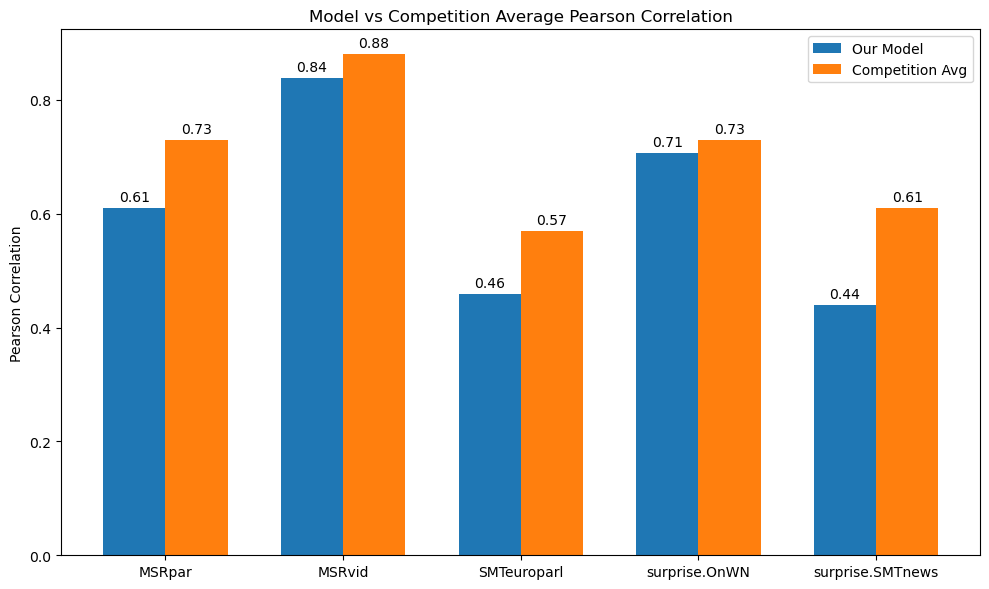

In [8]:
from scripts.compare_results import plot_pearson_comparison

# Competition average Pearson correlations
competition_averages = {
    "MSRpar": 0.73,
    "MSRvid": 0.88,
    "SMTeuroparl": 0.57,
    "surprise.OnWN": 0.73,
    "surprise.SMTnews": 0.61
}

fig, ax = plot_pearson_comparison(pearson_results, competition_averages)
plt.show()

In the previous bar chart, we can observe the performance of our best model across the five different datasets in the test set. We achieved a high Pearson correlation of 0.8386 in MSRvid, followed by a good performance in the OnWN dataset with a Pearson correlation of 0.7066. The next model performed moderately with a Pearson correlation of 0.609, and the last two models, SMTeuroparl and SMTnews, obtained very low Pearson correlations of 0.4588 and 0.439, respectively.

When we specifically analyze the types of sentences found in each dataset, we obtain the following descriptions. We also show the mean Pearson correlation obtained by all participants in SemEval-2012 Task 6 for each dataset:

- **MSRpar:** Sentences collected from news resources on the web. The mean Pearson correlation for this dataset is 0.73.
- **MSRvid:** Sentences describing actions or events in brief videos provided by annotators. The mean Pearson correlation for this dataset is 0.88.
- **SMTeuroparl:** Translations of sentences from French to English from the Workshops on Statistical Machine Translation (WMT). The mean Pearson correlation for this dataset is 0.57.
- **OnWN:** Glosses from OntoNotes and WordNet, which are large-scale linguistic resources for natural language processing. The mean Pearson correlation for this dataset is 0.73.
- **SMTnews:** Translations of sentences from French to English from news conversations. The mean Pearson correlation for this dataset is 0.61.
With the obtained Pearson correlations, the description of each dataset, and the average Pearson correlation in the competition, we can draw the following conclusions.

First, the MSRvid dataset achieves the highest Pearson correlation with our best model (0.838) and is also close to the competition average (0.88), although our Pearson correlation is slightly lower than the average. Our second highest Pearson correlation is in OnWN with 0.706, which also aligns with the competition average, placing second alongside MSRpar with a Pearson correlation of 0.73. Again, our Pearson correlation is slightly below the average. For the third dataset, MSRpar, we obtained a Pearson correlation much lower than the competition average at 0.61, which is 0.12 points less. For the fourth and fifth datasets, SMTeuroparl and SMTnews, we also have a significant difference from the competition average Pearson correlations, with 0.12 and 0.17 points lower, respectively.

Although we achieved a good average Pearson correlation of 0.757, our model performed well below expectations in the SMT and MSRpar datasets, and slightly below in MSRvid and OnWN. Analyzing the content of the sentences, we observe a trend in both our results and the competition results that it is more difficult to classify similarity between sentences when they are translations from one language to another, in this case from French to English. For everyday phrases, such as those found in news sentences in MSRpar or that are part of NLP glosses in OnWN, models generally perform better.

# **6. Comparison with Official Results**

To contextualize our results, we compare them against the top 10 results from the SemEval-2012 Task 6 competition and the baseline model.

In [7]:
y_true = test_data["score"]
y_pred = model.predict(features_test)
pearson_corr = pearsonr(y_true, y_pred)[0]

# Normalize predictions using linear transformation
all_gold_scores = np.array(y_true)
all_predictions = np.array(y_pred)

beta_1, beta_2 = np.polyfit(all_predictions, all_gold_scores, 1)
normalized_predictions = all_predictions * beta_1 + beta_2

# Calculate normalized Pearson correlation
normalized_pearson_corr, _ = pearsonr(normalized_predictions, all_gold_scores)

# Calculate weighted mean of Pearson
dataset_sizes = [len(test_data[test_data["dataset_name"] == d]) for d in pearson_results]
all_mean = sum([r * n for r, n in zip(pearson_results.values(), dataset_sizes)]) / sum(dataset_sizes)

best_results = {
    "Run": "our_model",
    "ALL": pearson_corr, "Rank_ALL": 0,
    "ALLnrm": normalized_pearson_corr, "Rank_ALLnrm": 0,
    "Mean": all_mean, "Rank_Mean": 0,
    "MSRpar": pearson_results["MSRpar"],
    "MSRvid": pearson_results["MSRvid"],
    "SMT-eur": pearson_results["SMTeuroparl"],
    "On-WN": pearson_results["surprise.OnWN"],
    "SMT-news": pearson_results["surprise.SMTnews"]
}

In [ ]:
from scripts.compare_results import compare_results_extended

# Load Official Results from SemEval-2012 Task 6
official_results = pd.read_csv('results/official_results_all.csv')

official_results_top10 = compare_results_extended(official_results, best_results)

# Save top 10 to CSV
official_results_top10.to_csv('results/official_results_top10.csv')

official_results_top10

,Run,ALL,Rank_ALL,ALLnrm,Rank_ALLnrm,Mean,Rank_Mean,MSRpar,MSRvid,SMT-eur,On-WN,SMT-news,Rank_MSRpar,Rank_MSRvid,Rank_SMT-eur,Rank_On-WN,Rank_SMT-news
0,baer/task6-UKP-run2_plus_postprocessing_smt_twsi,0.823900,1,0.857900,2,0.677300,1,0.683000,0.873900,0.528000,0.66410,0.493700,3,3,5,16,9
1,jan_snajder/task6-takelab-syntax,0.813800,2,0.856900,3,0.660100,4,0.698500,0.862000,0.361200,0.70490,0.468300,2,7,60,6,15
2,jan_snajder/task6-takelab-simple,0.813300,3,0.863500,1,0.675300,2,0.734300,0.880300,0.477100,0.67970,0.398900,1,1,24,9,42
3,baer/task6-UKP-run1,0.811700,4,0.855900,4,0.670800,3,0.682100,0.870800,0.511800,0.66490,0.467200,4,4,11,15,16
4,rada/task6-UNT-IndividualRegression,0.784600,5,0.844000,6,0.616200,13,0.535300,0.875000,0.420300,0.67150,0.403300,35,2,53,10,40
5,mheilman/task6-ETS-PERPphrases,0.783400,6,0.808900,27,0.639900,7,0.639700,0.720000,0.485000,0.71240,0.531200,7,50,19,2,4
6,mheilman/task6-ETS-PERP,0.780800,7,0.806400,32,0.630500,11,0.621100,0.721000,0.472200,0.70800,0.514900,11,49,28,4,6
7,baer/task6-UKP-run3_plus_random,0.779000,8,0.816600,19,0.432000,70,0.683000,0.873900,0.528000,-0.06200,-0.052000,3,3,5,84,85
8,rada/task6-UNT-IndividualDecTree,0.767700,9,0.838900,9,0.594700,25,0.569300,0.868800,0.420300,0.64910,0.225600,26,6,53,22,74
9,our_model,0.757578,10,0.757578,61,0.644243,6,0.609769,0.838675,0.458878,0.70664,0.439523,15,10,34,5,25


We can see that our model has ranked tenth overall for the average Pearson correlation of 0.757578. For the normalized Pearson correlation, we ranked significantly lower, placing 61st out of a total of 90 participants. However, for the weighted average Pearson correlation, we achieved sixth place, which positions us quite high in the rankings and demonstrates our model's strong performance.

We have also calculated the rankings for each of the datasets. For MSRpar, we secured the 15th position; for MSRvid, the 10th; and for OnWN, the 5th—all of which are relatively high in the classification. SMT-news performed worse, ranking 25th, and SMT-eur had the lowest performance, ranking 34th. However, considering there are a total of 90 participants, we are above the median in all datasets, and in some datasets, our performance is excellent.

# **7. Feature Importance Analysis**

We believe it is important to identify which features are most influential in the final model for classifying each pair of sentences. Below, we present a bar chart displaying each feature sorted by their importance.

In [12]:
# Extract the importance from each feature
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': features_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


In [23]:
def plot_feature_importances(model, model_name, features_train, ax=None, show_legend=True):
    """
    Plots the feature importances for a given model, highlighting syntactic and lexical features.

    Parameters:
        model (sklearn estimator): The trained model with a `feature_importances_` attribute.
        model_name (str): The name of the model (e.g., 'Mixed', 'Syntactic', 'Lexical').
        features_train (pd.DataFrame): The training features used to train the model.
        ax (matplotlib Axes, optional): The axes to plot on. If None, creates a new figure.
        show_legend (bool): Whether to show the legend.

    Returns:
        None: Displays the plot on the provided Axes.
    """
    importances = model.feature_importances_
    feature_importances = pd.DataFrame({
        'Feature': features_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=True)

    syntactic_features = [
        'pathlen_similarity', 'lin_similarity', 'average_similarity',
        'wordnet_augmented_word_overlap', 'wordnet_augmented_overlap',
        'weighted_word_overlap', 'pos_2_ngram_overlap',
        'pos_3_ngram_overlap', 'pos_4_ngram_overlap'
    ]

    feature_colors = [
        cm.tab10.colors[1] if feature in syntactic_features else cm.tab10.colors[0]
        for feature in feature_importances['Feature']
    ]

    if ax is None:
        ax = plt.gca()

    ax.barh(feature_importances['Feature'], feature_importances['Importance'], color=feature_colors)
    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Feature')
    ax.set_title(f'Feature Importances for the {model_name} Model')

    if show_legend:
        ax.legend(handles=[
            plt.Line2D([0], [0], color=cm.tab10.colors[1], lw=4, label='Syntactic'),
            plt.Line2D([0], [0], color=cm.tab10.colors[0], lw=4, label='Lexical')
        ], loc='upper right', bbox_to_anchor=(1, 0.9))

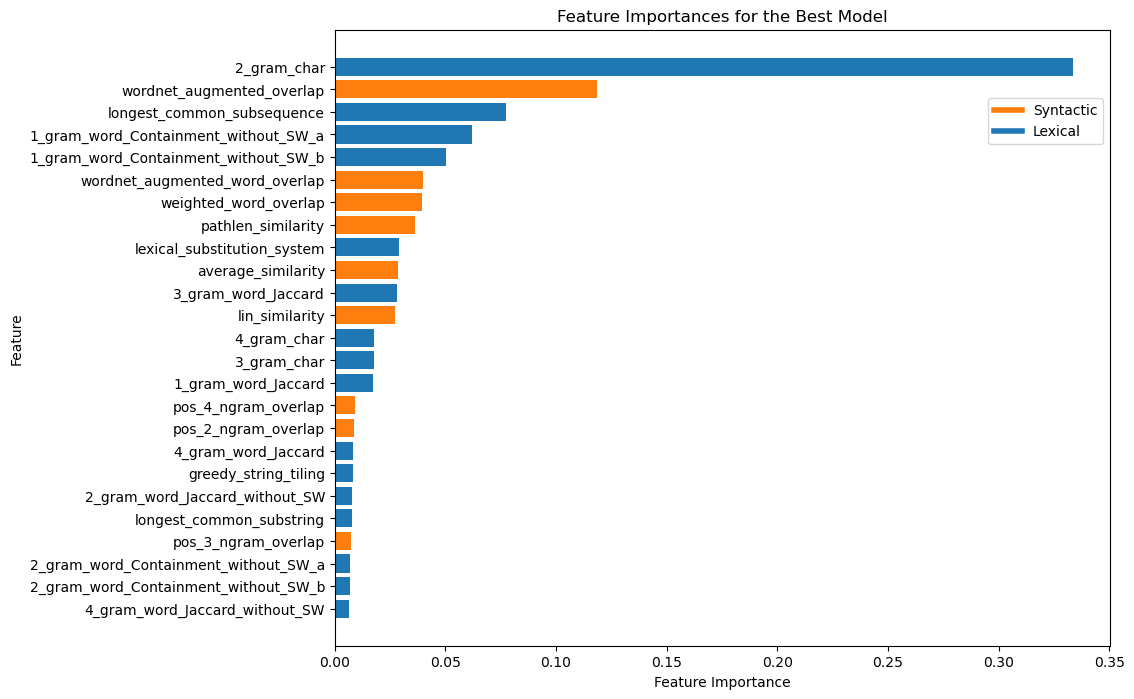

In [27]:
plt.figure(figsize=(10, 8))
plot_feature_importances(model, 'Best', features_train)
plt.savefig("plots/best_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

The bar chart displays the importance of each feature in the selected model. Features with higher importance scores contribute more significantly to the model's predictions, while those with lower scores have less influence.

From the chart, we observe that certain features, such as `2_gram_char` and `wordnet_augmented_overlap` have high importance, indicating they are crucial in determining sentence similarity. These features capture essential aspects of lexical and semantic similarity effectively. On the other hand, features like `4_gram_word_Jaccard_without_SW` and `pos_3_ngram_overlap` show lower importance, suggesting they have a minimal impact on the model's decisions.

`2_gram_chart` is the most important feature by a significant margin, possibly indicating that lexical features perform exceptionally well for these datasets. Following this feature, there is a well-balanced distribution between lexical and syntactic features, with the next most important feature being the syntactic `wordnet_augmented_overlap`, followed by three lexical features and then three syntactic features. In the next graph, we will display the feature importance of our best model for each dataset.

# **8. Exploration of Model Feature Dimensions**

In this section, we will train our best model using the same configuration but now with only lexical features and only syntactic features. We will have a total of three models: the best model we currently have with both lexical and syntactic features, the second model trained solely with lexical features, and the third model trained solely with syntactic features.

We aim to specifically analyze how feature importance changes depending on the type of features used to train the models, as well as the differences in the performance of each model. This will help us determine whether using only lexical or syntactic features can maintain the results we already have or if performance will significantly decline. Additionally, we will conduct a study for each dataset to see if lexical features perform better for one type of dataset or if syntactic features are more effective for another.

## Mixed Model

In [7]:
# Path to the saved Best Model
best_model_path = 'models/best_model.joblib'

# Load the saved model
model = joblib.load(best_model_path)

# Extract hyperparameters
best_params = model.get_params()

In [8]:
# Actual scores from the test set
y_true = test_data["score"]

# Predict scores using the selected model
y_pred_mixed = model.predict(features_test)

# Pearson correlation between actual and predicted scores
pearson_corr_mixed = pearsonr(y_true, y_pred_mixed)[0]

pearson_results_mixed = compute_pearsons_by_dataset(test_data, features_test, model)

Dataset: MSRpar, Pearson Correlation: 0.6097693001022645
Dataset: MSRvid, Pearson Correlation: 0.8386748282534271
Dataset: SMTeuroparl, Pearson Correlation: 0.4588782601632434
Dataset: surprise.OnWN, Pearson Correlation: 0.7066395838074657
Dataset: surprise.SMTnews, Pearson Correlation: 0.439522571834905


## Syntactic Model

In [9]:
# Define syntactic features
syntactic_features_names = [
    'pathlen_similarity', 'lin_similarity', 'average_similarity', 
    'wordnet_augmented_word_overlap', 'wordnet_augmented_overlap',
    'weighted_word_overlap', 'pos_2_ngram_overlap', 
    'pos_3_ngram_overlap', 'pos_4_ngram_overlap'
]

features_train_syntactic = features_train_shuffled[syntactic_features_names].copy()
features_test_syntactic  = features_test[syntactic_features_names].copy()

# Gradient Boosting Regressor
syntactic_model = GradientBoostingRegressor(**best_params)

# Fit Gradient Boosting
syntactic_model.fit(features_train_syntactic, score_shuffled)

# Cross-validation with the Best Model
cv_scores_syntactic = cross_val_score(syntactic_model, features_train_syntactic, score_shuffled, cv=10, scoring=pearson_scorer)

print("Syntactic Gradient Boosting - Pearson Correlation Scores:", cv_scores_syntactic)
print("Syntactic Gradient Boosting - Mean Pearson Correlation:", cv_scores_syntactic.mean(), "\n")

# Actual scores from the test set
y_true = test_data["score"]

# Predict scores using the selected model
y_pred_syntactic = syntactic_model.predict(features_test_syntactic)

# Pearson correlation between actual and predicted scores
pearson_corr_syntactic = pearsonr(y_true, y_pred_syntactic)[0]
print("Syntactic Pearson Correlation:", pearson_corr_syntactic, "\n")

pearson_results_syntactic = compute_pearsons_by_dataset(test_data, features_test_syntactic, syntactic_model)
print(pearson_results_syntactic)

Syntactic Gradient Boosting - Pearson Correlation Scores: [0.80553694 0.79418603 0.84665191 0.83981295 0.79741662 0.83652941
 0.78429421 0.79033075 0.85356632 0.86454118]
Syntactic Gradient Boosting - Mean Pearson Correlation: 0.8212866341367538 

Syntactic Pearson Correlation: 0.684700508207331 

Dataset: MSRpar, Pearson Correlation: 0.5735170457796733
Dataset: MSRvid, Pearson Correlation: 0.7905152592021809
Dataset: SMTeuroparl, Pearson Correlation: 0.44599859311201173
Dataset: surprise.OnWN, Pearson Correlation: 0.6628043111173902
Dataset: surprise.SMTnews, Pearson Correlation: 0.3306257798292262
{'MSRpar': 0.5735170457796733, 'MSRvid': 0.7905152592021809, 'SMTeuroparl': 0.44599859311201173, 'surprise.OnWN': 0.6628043111173902, 'surprise.SMTnews': 0.3306257798292262}


In [11]:
# Path to the Syntactic Model
syntactic_model_path = 'models/syntactic_model.joblib'

# Save the Syntactic Model
joblib.dump(syntactic_model, syntactic_model_path)
print(f"Syntactic model saved to {syntactic_model_path}")

Syntactic model saved to models/syntactic_model.joblib


## Lexical Model

In [10]:
# Define lexical features
lexical_features_names = [feature for feature in features_train.columns if feature not in syntactic_features_names]

features_train_lexical = features_train_shuffled[lexical_features_names].copy()
features_test_lexical  = features_test[lexical_features_names].copy()

# Gradient Boosting Regressor
lexical_model = GradientBoostingRegressor(**best_params)

# Fit Gradient Boosting
lexical_model.fit(features_train_lexical, score_shuffled)

# Cross-validation with the Best Model
cv_scores_lexical = cross_val_score(syntactic_model, features_train_lexical, score_shuffled, cv=10, scoring=pearson_scorer)

print("Lexical Gradient Boosting - Pearson Correlation Scores:", cv_scores_syntactic)
print("Lexical Gradient Boosting - Mean Pearson Correlation:", cv_scores_syntactic.mean(), "\n")

# Predict scores using the selected model
y_pred_lexical = lexical_model.predict(features_test_lexical)

# Pearson correlation between actual and predicted scores
pearson_corr_lexical = pearsonr(y_true, y_pred_lexical)[0]
print("Lexical Pearson Correlation:", pearson_corr_lexical, "\n")

pearson_results_lexical = compute_pearsons_by_dataset(test_data, features_test_lexical, lexical_model)
print(pearson_results_lexical)

Lexical Gradient Boosting - Pearson Correlation Scores: [0.80553694 0.79418603 0.84665191 0.83981295 0.79741662 0.83652941
 0.78429421 0.79033075 0.85356632 0.86454118]
Lexical Gradient Boosting - Mean Pearson Correlation: 0.8212866341367538 

Lexical Pearson Correlation: 0.7244199575931274 

Dataset: MSRpar, Pearson Correlation: 0.5707948084199164
Dataset: MSRvid, Pearson Correlation: 0.8072912767552867
Dataset: SMTeuroparl, Pearson Correlation: 0.48194503902789065
Dataset: surprise.OnWN, Pearson Correlation: 0.6922862146813797
Dataset: surprise.SMTnews, Pearson Correlation: 0.42480083664991664
{'MSRpar': 0.5707948084199164, 'MSRvid': 0.8072912767552867, 'SMTeuroparl': 0.48194503902789065, 'surprise.OnWN': 0.6922862146813797, 'surprise.SMTnews': 0.42480083664991664}


In [13]:
# Path to the Lexical Model
lexical_model_path = 'models/lexical_model.joblib'

# Save the Syntactic Model
joblib.dump(lexical_model, lexical_model_path)
print(f"Lexical model saved to {lexical_model_path}")

Lexical model saved to models/lexical_model.joblib


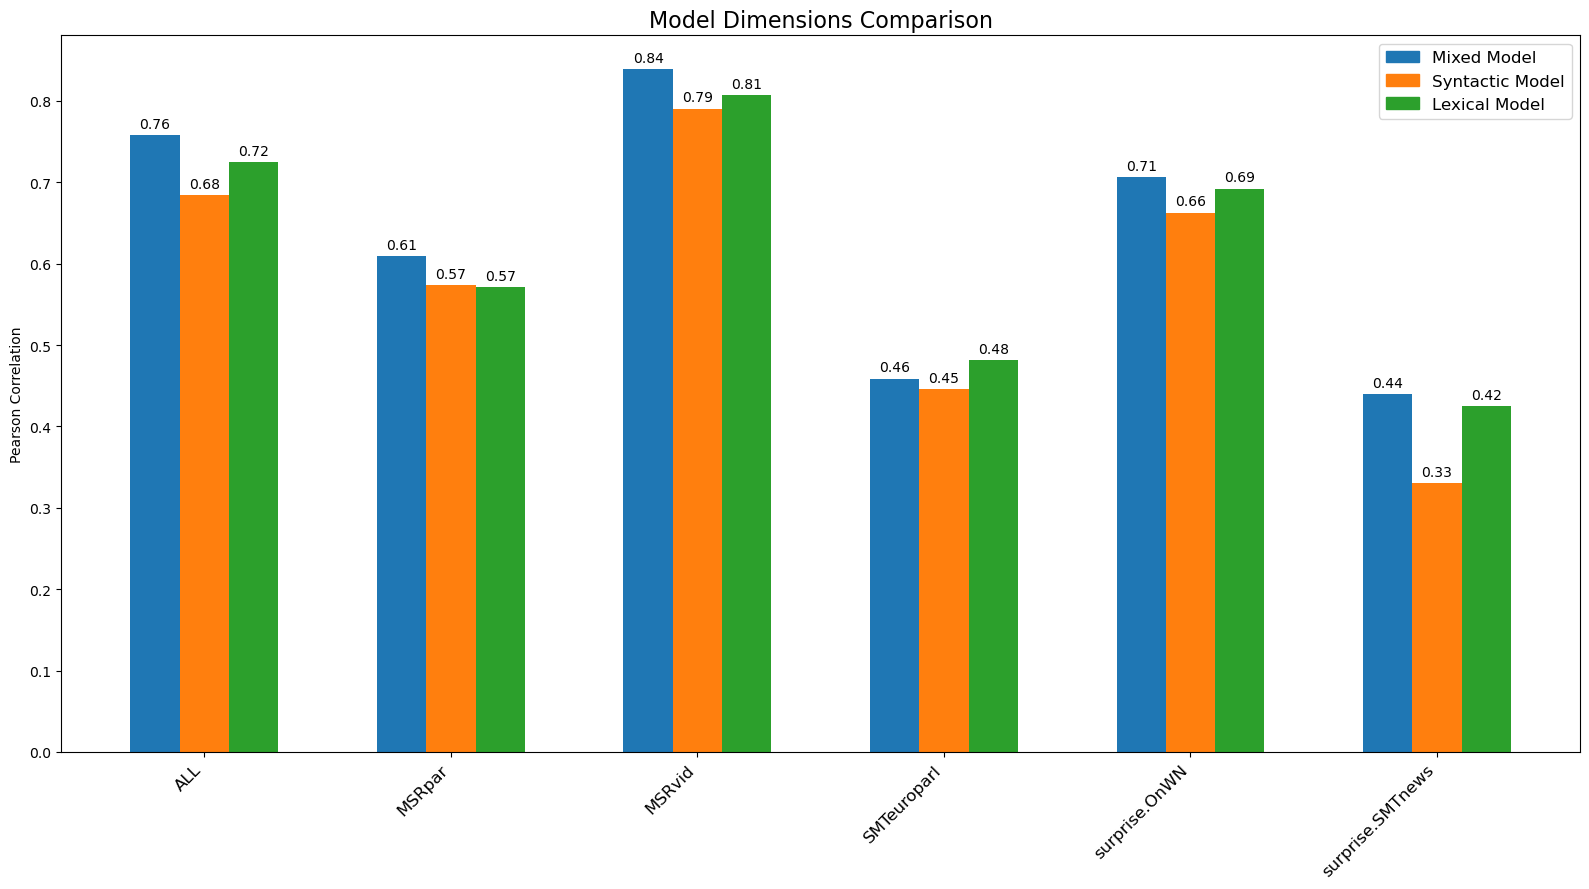

In [ ]:
from scripts.compare_results import plot_pearson_comparison2

fig, ax = plot_pearson_comparison2(pearson_results_mixed, pearson_corr_mixed, pearson_results_syntactic, pearson_corr_syntactic,
    pearson_results_lexical, pearson_corr_lexical)

# Save the plot
fig.savefig('plots/model_dimensions.png')

plt.show()

In the previous graph, we can see the overall Pearson correlation values for the entire test set labeled 'ALL' and the Pearson correlation values for each specific dataset. For each of them, we display the Pearson correlations for the mixed model, the syntactic model, and the lexical model.

We observe that the results are not as straightforward as they might seem. Using only lexical or only syntactic features can, in some cases, improve the model's performance.

Average: Using the mixed model provides the best results with a Pearson correlation of 0.76. Using only lexical features slightly reduces the Pearson correlation to 0.72, and using only syntactic features reduces it significantly to 0.68. This suggests that, in general, lexical features may perform better than syntactic features, although the best case is always a mixed model that leverages the strengths of both dimensions.

- **MSRpar:** The mixed model again provides the best results with a Pearson correlation of 0.61. Using only lexical or only syntactic models both achieve the same result of 0.57. This indicates that, for MSRpar, the importance of lexical and syntactic features in identifying similarity between sentence pairs is well balanced.

- **MSRvid:** We once again obtain the highest Pearson correlation with the mixed model. Using only lexical features slightly reduces the Pearson correlation to 0.81, and using only syntactic features reduces it to 0.79. Similar to the previous dataset, the results of the lexical and syntactic models are very similar, suggesting a balance between these features in the MSRvid dataset. However, the combination of both still yields better results.

- **SMTeuroparl:** In this case, using only lexical features achieves a better Pearson correlation than the mixed model. The mixed model obtains a Pearson correlation of 0.46, and the syntactic model achieves 0.45, while the lexical model obtains 0.48. Although the difference between models is very small, the better performance using only lexical features suggests that, for this dataset, lexical features are more important. This makes sense considering that the dataset contains translations from French to English, with some French words present in the sentences. Since we only use the English dictionary from NLTK to process syntactic features, most French words are not correctly detected as they do not belong to the English dictionary, resulting in a loss of meaning in these cases. On the other hand, lexical features can capture some similarity between French and English words, allowing information to be derived from the form of the words. For example, we find words like "régresseront," "aujourd'hui," "transférables," and others, as well as misspelled words that are not in the English dictionary, such as "makesit," which lowers the performance of syntactic features.

- **OnWN:** The mixed model again provides the best results with a Pearson correlation of 0.71, followed by the lexical model with 0.69 and the syntactic model with 0.66. In this case, the differences between the three models are small, and we cannot definitively say that one type of feature works better for this dataset, although there is a slight preference for lexical features.

- **SMTnews:** We reinforce the conclusion that syntactic features perform poorly when we have words from other languages that are not part of the English dictionary. Like SMTeuroparl, SMTnews contains translations of sentences from French to English. In this case, using only syntactic features results in a much lower Pearson correlation than using lexical or mixed features. We obtain the highest Pearson correlation with the mixed model at 0.44, closely followed by the lexical model at 0.42. For the model that uses only syntactic features, the Pearson correlation obtained is 0.33, the lowest of all and the one with the greatest difference compared to the other two models across all datasets. Among the French words, we find "pro-marché," "pénétrante," "répudiation," "désinstitutionalisation," "écartait," and many others present in the SMTeuroparl dataset. This is why, in this case, using only syntactic features significantly worsens performance.

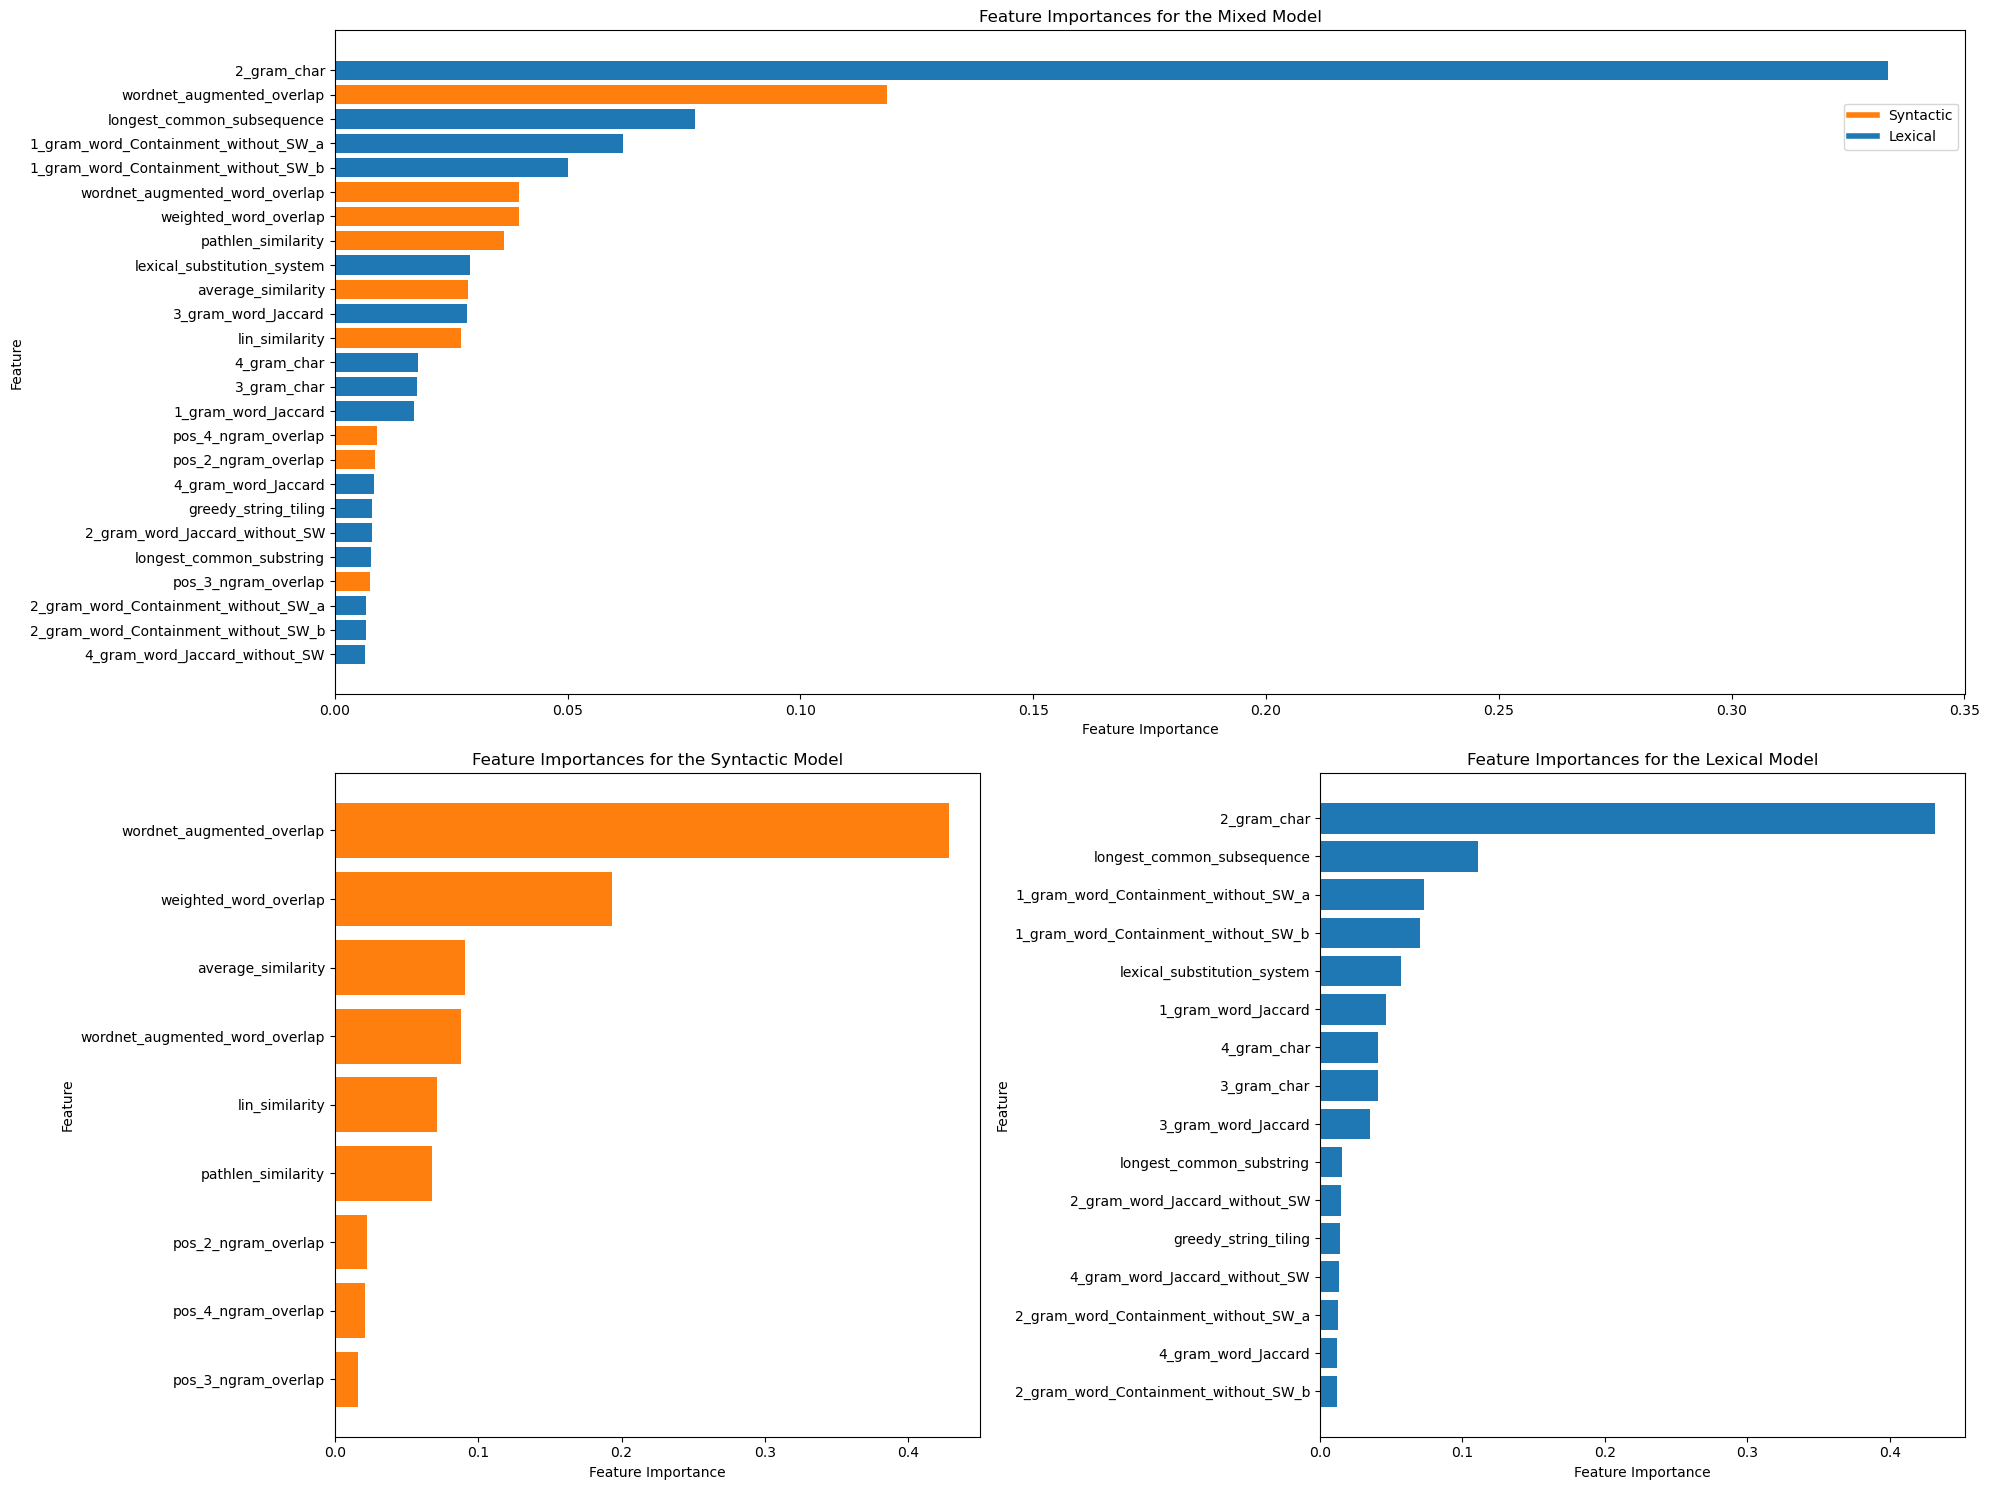

In [ ]:
# Create a 2x2 subplot grid
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 2, figure=fig)

# Plot Mixed model spanning the top row
ax_mixed = fig.add_subplot(gs[0, :])  # Span [0, 0] and [0, 1]
plot_feature_importances(model, 'Mixed', features_train, ax=ax_mixed)

# Plot Syntactic model in the bottom-left
ax_syntactic = fig.add_subplot(gs[1, 0])
plot_feature_importances(syntactic_model, 'Syntactic', features_train_syntactic, ax=ax_syntactic, show_legend=False)

# Plot Lexical model in the bottom-right
ax_lexical = fig.add_subplot(gs[1, 1])
plot_feature_importances(lexical_model, 'Lexical', features_train_lexical, ax=ax_lexical, show_legend=False)

# Save the figure
#plt.savefig("plots/feature_importance_by_dimensions.png", dpi=300, bbox_inches='tight')

# Adjust layout and show
plt.tight_layout()
plt.show()

Observing the feature importances for the mixed model, the lexical model, and the syntactic model, we can see that changes occur in the order of feature importances.

In the syntactic model, `wordnet_augmented_overlap` remains the most important syntactic feature. In the mixed model, the second and third most important syntactic features are `wordnet_augmented_word_overlap` and `weighted_word_overlap`, both with equal importance. For the syntactic model, `weighted_word_overlap` continues to be the second most important syntactic feature, while `wordnet_augmented_word_overlap` has dropped to the fifth position, significantly reducing its importance compared to the mixed model. The third most important feature is `average_similarity`, which was slightly behind the two previous features in the mixed model. The following features also show some differences, such as `pathlen_similarity` being the fourth most important in the mixed model and now the sixth; and `pos_2_ngram_overlap` being more important than `pos_4_ngram_overlap` in the syntactic model.

In the lexical model, `2_gram_char` remains by far the most important lexical feature, followed by `longest_common_subsequence` and `1_gram_word_Containment_without_SW_a`, in the same order as the mixed model. There are some differences in the less important features of the lexical model. For example, the features `1_gram_word_Jaccard` and `4_gram_word_Jaccard_without_SW` are now more important than they are in the mixed model.

These changes in feature importance demonstrate that when only lexical or syntactic features are present, the importance of a feature depends on the combination of features with which it is grouped. We have observed that certain features become more or less important depending on whether they are grouped solely with lexical or syntactic features instead of being part of a mixed set. This means that, for example, in the lexical model, the feature `1_gram_word_Jaccard` can provide more relevant information when only lexical features are used compared to when there is a mixture of lexical and syntactic features.


# **Conclusions**

In this project, we successfully implemented and trained three different classifiers to predict the similarity between pairs of sentences. We analyzed the results obtained for each dataset and explained our reasoning for achieving better or worse results depending on the dataset. We also compared our results with those from the official SemEval-2012 Task 6 competition to assess how well our model performed. We observed that we achieved very good results, securing the tenth position in the overall Pearson correlation among 90 participants, and also performed well with other metrics such as the weighted mean, where we ranked sixth. In the datasets MSRpar, MSRvid, and OnWN, we obtained excellent results, ranking 15th, 10th, and 5th in Pearson correlation, respectively. Additionally, we conducted a feature correlation analysis to identify which features were most important in our final model. We observed that the feature with the most significant difference is a lexical feature `2_gram_char`, followed by a syntactic feature `wordnet_augmented_overlap`, and then balanced features comprising both lexical and syntactic types. We can argue that there is a tendency to favor lexical features, although we also maintain a good balance between lexical and syntactic features.

We also trained models using only lexical features and only syntactic features and compared them among themselves and with our current best model, which is the mixed model. We observed that the mixed model predominated in most cases, but sometimes the lexical features surpassed or were very close to the Pearson correlation of the mixed model. In the case of the model with only syntactic features, it performed slightly below the mixed and lexical models in some instances and much lower in two specific datasets. We also analyzed the feature importance of these models and observed changes in the order of feature importances; some features provided more importance when the other type of features was not present.

In conclusion, balancing lexical and syntactic features in the mixed model provides the best results, demonstrating the importance of including both types of features when analyzing the similarity between pairs of sentences. The type and context of the sentences also play a significant role when attempting to analyze their similarity. We have seen that in certain cases, some datasets with specific types of sentences achieved very good results, while for other datasets with different types of classes, our model performed better. It is important to consider the origin and nature of the classes and the types of features we include in our model to achieve good results.

For future work, we believe it is necessary to implement other types of features, such as stylistic features, to cover more aspects of the texts and to obtain additional information. We also consider it essential to implement more lexical and syntactic features and to perform feature selection to identify the best combination of features.

# **References**

[1]: [UKP: Computing Semantic Textual Similarity by Combining Multiple Content Similarity Measures](https://aclanthology.org/S12-1059.pdf) (Bär et al., SemEval-*SEM 2012)

[2]: [TakeLab: Systems for Measuring Semantic Text Similarity](https://aclanthology.org/S12-1060.pdf) (Šarić et al., SemEval-*SEM 2012)